# getting, processing, & transforming data for univariate model

### 1. necessary imports

In [29]:
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf

### 2. get FRED api key as env variable and get Real GDP as target variable
- this series includes later revisions which introduces look-ahead bias, real production should probably use real-time vintages

In [8]:
fred_api_key = os.getenv('FRED_API_KEY', default=None)
if fred_api_key is None:
    raise ValueError('FRED_API_KEY environment variable is not set')

fred = Fred(api_key=fred_api_key)
gdp_raw = fred.get_series('GDPC1')

gdp_raw

1947-01-01     2182.681
1947-04-01     2176.892
1947-07-01     2172.432
1947-10-01     2206.452
1948-01-01     2239.682
                ...    
2024-01-01    23053.545
2024-04-01    23223.906
2024-07-01    23400.294
2024-10-01    23542.349
2025-01-01    23526.085
Length: 313, dtype: float64

### 3. Ensure quarterly frequency
- GDPC1 comes from FRED timestamped at quarter *end*
- This guarantees equal spacing between periods

In [14]:
gdp_q = gdp_raw.asfreq('QS')
assert gdp_q.isna().sum() == 0, 'unexpected NA'

gdp_q

1947-01-01     2182.681
1947-04-01     2176.892
1947-07-01     2172.432
1947-10-01     2206.452
1948-01-01     2239.682
                ...    
2024-01-01    23053.545
2024-04-01    23223.906
2024-07-01    23400.294
2024-10-01    23542.349
2025-01-01    23526.085
Freq: QS-JAN, Length: 313, dtype: float64

<Axes: >

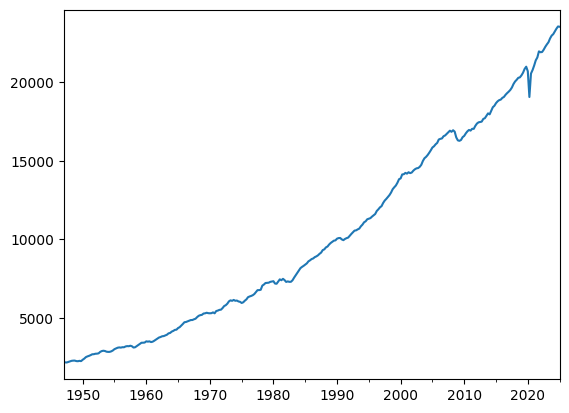

In [12]:
gdp_q.plot()

### 4. YoY % Change
- Using $\Delta GDP_t = \frac{GDP_t}{GDP_{t-4}} * 100\%$
- More lagged than QoQ and loses three data points at the beginning but provides smoothing and is roughly more stationary

In [15]:
gdp_yoy = gdp_q.pct_change(periods=4) * 100
gdp_yoy.name = "GDP_YoY"
gdp_yoy.dropna(inplace=True) # drops first four data points

gdp_yoy

1948-01-01    2.611513
1948-04-01    4.584426
1948-07-01    5.401228
1948-10-01    3.893672
1949-01-01    0.943214
                ...   
2024-01-01    2.901832
2024-04-01    3.036849
2024-07-01    2.718769
2024-10-01    2.533684
2025-01-01    2.049750
Freq: QS-JAN, Name: GDP_YoY, Length: 309, dtype: float64

In [19]:
gdp_yoy.describe()

count    309.000000
mean       3.152052
std        2.631344
min       -7.502366
25%        1.933559
50%        3.049756
75%        4.484493
max       13.372394
Name: GDP_YoY, dtype: float64

<Axes: xlabel='GDP_YoY', ylabel='Count'>

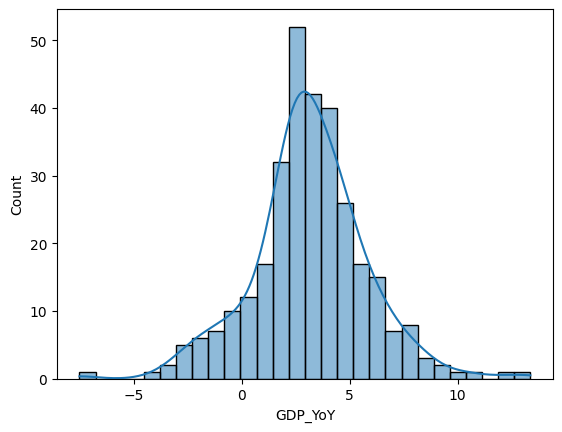

In [20]:
sns.histplot(data=gdp_yoy, kde=True)

<Axes: >

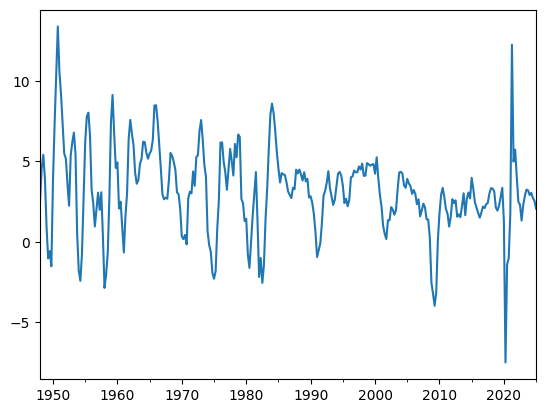

In [21]:
gdp_yoy.plot()

### 5. Stationarity check
- the second returned number is MacKinnon's approximate p-value (should be <0.05)
- MS-AR model assumes weak stationarity

In [24]:
adfuller(gdp_yoy)

(np.float64(-3.237867032997031),
 np.float64(0.01789478774864169),
 16,
 292,
 {'1%': np.float64(-3.4529449243622383),
  '5%': np.float64(-2.871489553425686),
  '10%': np.float64(-2.572071437887033)},
 np.float64(954.2673533519433))

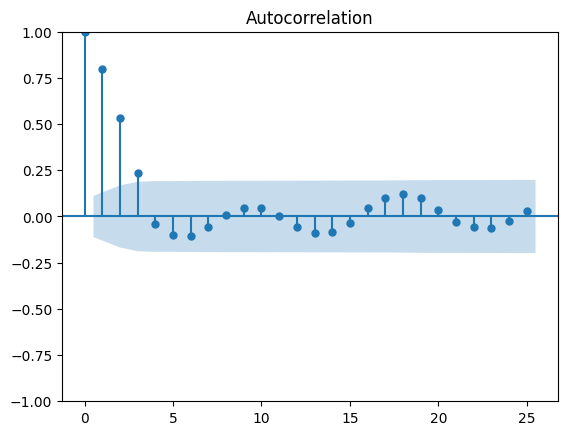

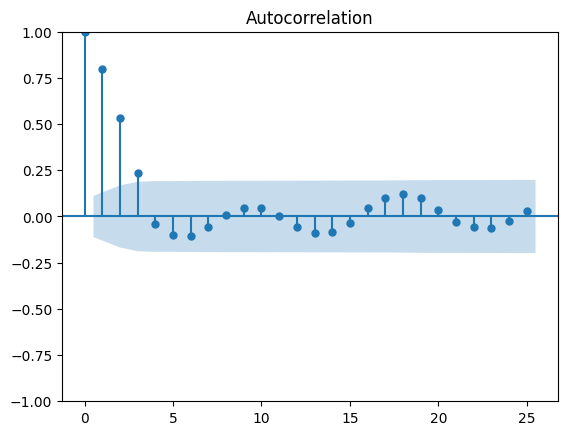

In [30]:
plot_acf(gdp_yoy)

In [33]:
gdp_yoy.to_csv('MS-AR/data/gdp_yoy.csv')